# Import Libraries

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os # accessing directory structure
import numpy as np  
import pandas as pd
import json

import glob as gb
import re

from PIL import Image
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
try:
  from torchsummary import summary  # 깔끔하게 pytorch 출력
  import pjson  # python -m json.tool와 같이 깔끔하게 json 출력
except:
  !pip install torchsummary
  from torchsummary import summary
  !pip install pjson
  import pjson

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pjson: filename=pjson-1.1-py3-none-any.whl size=3547 sha256=8f62eccdcd7537c09cb264228f7587dc01ad6947c94d3519319fa524648e266f
  Stored in directory: /root/.cache/pip/wheels/52/c3/8e/f5ba96ab8fc6956300bf61a7bbd467dd1dc36ee1a029773331
  Created wheel for xmlformatter: filename=xmlformatter-0.1.1-py3-none-any.whl size=10410 sha256=817dbaa3da7e13e5e4bf1926c7e9286c07dcbfe3c3ec1f60565cb8c0d2eb7a94
  Stored in directory: /root/.cache/pip/wheels/97/c4/2b/29db6473a33823617f70ef7c10f9bfa40bff2180b88d772cbf
Successfully built pjson xmlformatter


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing (1) 

In [4]:
%cd /content/drive/MyDrive/sign_recognition/datasets
# 직접촬영_매장전경 / 크롤링_매장전경 dataset 있는 파일 경로로 이동
%ls

/content/drive/MyDrive/sign_recognition/datasets
직접촬영_매장전경_annotation_LowQuality_new.zip
크롤링_매장전경_Annotation_new.zip


In [5]:
root = '/content/drive/MyDrive/sign_recognition/datasets' # root path 지정

In [6]:
# unzip dataset 
!unzip -qq '직접촬영_매장전경_annotation_LowQuality_new.zip'

In [7]:
# unzip dataset 
!unzip -qq '크롤링_매장전경_Annotation_new.zip'

In [8]:
%ls

Annotation/
직접촬영_매장전경_annotation_LowQuality_new.zip
크롤링_매장전경_Annotation_new.zip
LowQuality/


In [9]:
# 보기 편하게 폴더 이름 변경 ('직접촬영' -> 'self', '크롤링' -> 'crawling')
os.rename(os.path.join(root, 'LowQuality'), os.path.join(root, 'self')) 
os.rename(os.path.join(root, 'Annotation'), os.path.join(root, 'crawling'))

In [10]:
self_path = '/content/drive/MyDrive/sign_recognition/datasets/self' # 직접촬영
crawling_path = '/content/drive/MyDrive/sign_recognition/datasets/crawling' # 크롤링

In [11]:
%cd /content/drive/MyDrive/sign_recognition/datasets/self
%ls

/content/drive/MyDrive/sign_recognition/datasets/self
K-TourNet_DS_Shop_Exterior_Annotation_LowQuality_01/
K-TourNet_DS_Shop_Exterior_Annotation_LowQuality_02/
K-TourNet_DS_Shop_Exterior_Annotation_LowQuality.json


In [12]:
# 직접촬영 dataset 파일 이름 변경
os.rename(os.path.join(self_path, 'K-TourNet_DS_Shop_Exterior_Annotation_LowQuality_01'), os.path.join(self_path, 'self_image_1')) 
os.rename(os.path.join(self_path, 'K-TourNet_DS_Shop_Exterior_Annotation_LowQuality_02'), os.path.join(self_path, 'self_image_2'))
os.rename(os.path.join(self_path, 'K-TourNet_DS_Shop_Exterior_Annotation_LowQuality.json'), os.path.join(self_path, 'self_annot.json'))

In [13]:
%ls

self_annot.json  self_image_1/  self_image_2/


In [14]:
%cd /content/drive/MyDrive/sign_recognition/datasets/crawling
%ls

/content/drive/MyDrive/sign_recognition/datasets/crawling
K-TourNet_CR_Shop_Exterior_Annotation/
K-TourNet_CR_Shop_Exterior_Annotation.json


In [15]:
# 크롤링 dataset 파일 이름 변경
os.rename(os.path.join(crawling_path, 'K-TourNet_CR_Shop_Exterior_Annotation'), os.path.join(crawling_path, 'crawling_image')) 
os.rename(os.path.join(crawling_path, 'K-TourNet_CR_Shop_Exterior_Annotation.json'), os.path.join(crawling_path, 'crawling_annot.json')) 

In [16]:
%ls

crawling_annot.json  crawling_image/


- [os.rename()또는os.replace()함수를 사용하여 Python에서 파일 이동](https://www.delftstack.com/ko/howto/python/python-move-file/)

In [18]:
# 직접촬영 self_image_1, self_image_2 폴더 한 파일 (self_image)로 merge 

# os.rename(os.path.join(self_path, 'self_image_1'), os.path.join(self_path, 'self_image'))
# os.rename(os.path.join(self_path, 'self_image_2'), os.path.join(self_path, 'self_image'))
try:
  os.mkdir(os.path.join(self_path, 'self_image'))
except:
  print('이미 파일이 존재합니다!')

이미 파일이 존재합니다!


In [19]:
%cd /content/drive/MyDrive/sign_recognition/datasets/self
%ls

/content/drive/MyDrive/sign_recognition/datasets/self
self_annot.json  self_image/  self_image_1/  self_image_2/


# Data Preprocessing (2) 

- [JSON 인코더와 디코더](https://docs.python.org/ko/3/library/json.html)
- [JSON 파일 인쇄 - Python](http://daplus.net/python-json-%ED%8C%8C%EC%9D%BC%EC%9D%84-%EC%9D%B8%EC%87%84%ED%95%98%EB%8A%94-%EB%B0%A9%EB%B2%95/)

In [20]:
def get_images(path):
  # files : a list of img path
  # names : a list of img name

  assert os.path.exists(path) == True & os.path.isdir(path) == True , f'해당 디렉토리{path}가 존재하지 않습니다.'  # assert 조건, 오류 메시지


  files = []
  for extension in ['jpg', 'png', 'jpeg', 'JPG']:  #확장명(extension)이 jpg, png, jpeg, JPG이면 가져오기
    files.extend(gb.glob(os.path.join(path, f'*.{extension}'))) # 해당 extension을 가진 파일 경로 모두 가져와 list로 반환
  
  names = os.listdir(path) # path 내의 모든 파일, 디렉토리의 list를 반환 (이미지 파일 리스트 가져오기 ex) 16817_24.jpg


  # Check
  for i in range(len(files)):
    # os.path.basename : 경로의 basename(기본 이름) 반환 (제일 뒤에 붙는 파일이나 폴더)
    assert os.path.basename(files[i])  == names[i], '이미지 경로와 이미지 이름이 상응하지 않습니다.'
  
  print(f'Total num of imgs : {len(files)}')

  files = sorted(files)
  names = sorted(names)

  print(f'files : {len(files)}, names : {len(names)}')
  return files, names

In [27]:
# 직접촬영
%cd /content/drive/MyDrive/sign_recognition/datasets/self
%ls

/content/drive/MyDrive/sign_recognition/datasets/self
self_annot.json  self_image/  self_image_1/  self_image_2/


In [22]:
# 직접촬영 annotaion json 파일 보기
!cat self_annot.json | pjson

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
          "annotation_kr": "바른닭발X챨쓰네치즈포차",
          "annotation_en": "Bareundakbaltyaeppopchyemchwangmotchwalmwaa\t",
          "annotation_cn": "",
          "annotation_jp": ""
        }
      }
    ],
    "file_attributes": {
      "dataSource": "tour POI",
      "imageSource": "직접촬영",
      "image_resolution": "저해상도",
      "labeling": "매장 전경, shop exterior, 店の外装, 商店外景",
      "rid": "101391",
      "title": "바른닭발X챨쓰네치즈포차",
      "addr": "서울특별시 용산구 이태원로19길 3",
      "latitude": "37.53462",
      "longitude": "126.991798",
      "tel": "02-4109-9559",
      "rlink": "http://www.redtable.global/restaurant_info.php?city=seoul&rid=101391\n"
    }
  },
  "IMG_20181003_135919_640_360.jpg36143": {
    "filename": "IMG_20181003_135919_640_360.jpg",
    "size": 36143,
    "regions": [
      {
        "shape_attributes": {
          "name": "rect",
          "x": 16,
          "y": 43,
          "width": 544,
          "height": 308
        },
        "re

In [23]:
with open(os.path.join(self_path, 'self_annot.json')) as annot_json:
          annot_py = json.load(annot_json)

In [24]:
def label_proocess(annot, key):
  import re
  region_dict = annot[key]['regions'][0]['region_attributes']

  if('annotation_kr' in region_dict):
    if (region_dict['annotation_kr'].strip('\n') != ''):
      text = region_dict['annotation_kr'].strip('\n')
      res1 = re.sub('\(\w+\)\n', '', text)
      res = re.sub('[^가-힣]', '', res1)
      return res

    else:
      if('annotation_en' in region_dict):
        text = region_dict['annotation_en'].strip('\n')
        res = re.sub(r'[^a-zA-z]', '', text)
        return res
  else:
    if ('annotation_en' in region_dict):
      text = region_dict['annotation_en'].strip('\n')
      res = re.sub(r'[^a-zA-z]', '', text)
      return res

In [25]:
def polygon_process(annot, key):
  global x
  global y
  shape_dict = annot_py[key]['regions'][0]['shape_attributes']
  if 'all_points_x' in shape_dict:
    x = shape_dict['all_points_x']
  else:
    x = []
    x.append(shape_dict['x'])

  if 'all_points_y' in shape_dict:   
    y = shape_dict['all_points_y']
  else:
    # all_points_y가 속성에 없는 경우 그냥 y(좌표 개수가 1개)
    y = []
    y.append(shape_dict['y'])

  return x, y

In [31]:
def get_annotation(path):
  annot_names = []
  labels = []
  polygons = []

  assert os.path.exists(path) == True, f'해당 파일{path}이 존재하지 않습니다.'  # assert 조건, 오류 메시지
  
  with open(path) as annot_json:
    annot_py = json.load(annot_json)
  
  for key in annot_py.keys():
    name = annot_py[key]['filename']
    annot_names.append(name)
    label = label_proocess(annot_py, key)
    labels.append(label)
    try:
      all_x, all_y = polygon_process(annot_py, key)
      # [[x1, y1], [x2, y2], [x3, y3], [x4, y4], ...]
      polygon = np.array(list(zip(all_x, all_y)), dtype=np.float32)
      polygons.append(polygon)
    except:
      print('오류', key)

  print(f'annotation 개수 : {len(annot_names)}, labels 개수 : {len(labels)}, polygons 개수 : {len(polygons)}')
  return annot_names, labels, polygons

In [28]:
self_files, self_names = get_images(os.path.join(self_path, 'self_image'))

Total num of imgs : 736
files : 736, names : 736


In [34]:
self_files[:10]

['/content/drive/MyDrive/sign_recognition/datasets/self/self_image/IMG_20180831_000001 (44)_640_360.jpg',
 '/content/drive/MyDrive/sign_recognition/datasets/self/self_image/IMG_20180831_150617_640_360.jpg',
 '/content/drive/MyDrive/sign_recognition/datasets/self/self_image/IMG_20180831_155807_640_360.jpg',
 '/content/drive/MyDrive/sign_recognition/datasets/self/self_image/IMG_20180903_144946_640_360.jpg',
 '/content/drive/MyDrive/sign_recognition/datasets/self/self_image/IMG_20180904_141137_640_360.jpg',
 '/content/drive/MyDrive/sign_recognition/datasets/self/self_image/IMG_20180904_141507_640_360.jpg',
 '/content/drive/MyDrive/sign_recognition/datasets/self/self_image/IMG_20180904_144011_640_360.jpg',
 '/content/drive/MyDrive/sign_recognition/datasets/self/self_image/IMG_20180904_145045_640_360.jpg',
 '/content/drive/MyDrive/sign_recognition/datasets/self/self_image/IMG_20180904_150619_640_360.jpg',
 '/content/drive/MyDrive/sign_recognition/datasets/self/self_image/IMG_20180904_161931

In [32]:
self_annot_names, self_labels, self_polygons = get_annotation(os.path.join(self_path, 'self_annot.json'))

annotation 개수 : 736, labels 개수 : 736, polygons 개수 : 736


In [30]:
print(self_labels, end='')

['너비집', '명동상구비어', 'sRADIOPUB', '삼대나주곰탕', '둘둘치킨명동호점', '카페코인', '명동대복', '라패', 'SideShow', '금강섞어찌개', '다마시떼', '누나홀닭', 'bhc', '매일맥주', '딴따라오뎅', '멜팅그릴', '갓덴스시', '명동돈가스', '고디바', '도쿄스테이크', '리퍼블릭명동점', '딘타이펑', 'YouareHere', '돈돼지', '라멘', '둘둘치킨명동호점', '명동내림손삼계탕', '맥도날드', '공차명동점', '낭만김밥', '김가네명동점', '레오니다스명동점', '명동고로케', '다도해물집', '곰국시집', '명동교자', '명동함흥면옥', 'TEMPTER', '구스띠모', '고기랑', '굳치맥', '명동마루', '고릴라김밥', '명동교자분점', '라화쿵뷰', '더식당명동점', '또아식빵', '빈스빈스명동점', '내가찜한닭', 'cafedeparis', 'Aha', '번가닭강정', '구슬함박', '대가', '레드홍명동점', '김대장', '고모네떢볶이', '밀키비', '디디치킨', '두르가종각점', 'RADOST', '썬샤인', '국자싸롱', '마마된장', '제이에스텍사스바종로점', '제이에스텍사스바종로점', 'TAPROOMtheTABLE', '맘스터치종각역점', '멸치국수잘하는집', '남산복집', '동해도', '에머이', '대성골뱅이', '맛있는김치찜순두부', '곰국시집', '그램그램종로점', '마포짚불구이곱창', '고기팩토리', '맛나호프', '교대이층집', '감성돔횟집', '맥주창고', '깔창', '떼아떼베네', 'jyoti', '겐로쿠우동명동점', '명동길신신', '얼큰수제비명동본점', '식사랑', '리원', '놀부부대찌개명동점', '마라탄탄면', '카페코인', '둘둘치킨명동호점', '딴따라오뎅', '매일맥주', 'bhc', '원조남산왕돈까스', '고봉삼계탕명동본점', '라패', 'Coffeeni', '갓덴스시', '금강섞어찌개', '낙동강', '동해일식', '누나홀닭', '명동내림손삼계탕', 

In [ ]:
class CustomDataset:
  def __init__(self, path, transform=None):
    self.path = path
    self.files, self.names = get_images(path)
    self.annot_names, self.labels, self.polygons = get_annotation(path)
  
  def __len__(self):
    assert len(self.files) == len(self.names) == len(self.annot_names) == len(self.labels) == len(self.polygons), '데이터 개수가 맞지 않습니다.'
    return len(self.files)

  def __getitem__(self, index):
    image_path = self.files[index]
    label = self.labels[index]

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_200x200 = cv2.resize(image, (200, 200))

    if self.transform:
      transformed = self.transform(image=image, bboxes = label)




# 데이터 분리
- train data / test data 분리

In [36]:
try:
  os.mkdir(os.path.join(root, 'test_image'))
  print('test_image 파일을 생성했습니다.')
except:
  print('이미 test_image 파일이 존재합니다.')

try:
  os.mkdir(os.path.join(root, 'test_annot'))
  print('test_annot 파일을 생성했습니다.')
except:
  print('이미 test_annot 파일이 존재합니다.')

test_image 파일을 생성했습니다.
test_annot 파일을 생성했습니다.


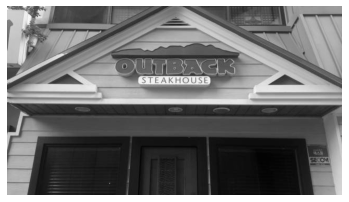

In [42]:
test = cv2.imread(self_files[0], cv2.IMREAD_GRAYSCALE)
plt.imshow(test, cmap='gray')
plt.axis('off');

(-0.5, 199.5, 199.5, -0.5)

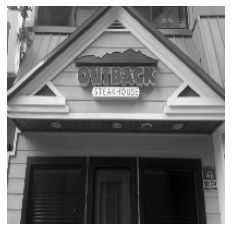

In [43]:
test_200x200 = cv2.resize(test, (200, 200))
plt.imshow(test_200x200, cmap='gray')
plt.axis('off')

In [44]:
thresh = 0
maxvalue = 255

th, dst = cv2.threshold(test, thresh, maxvalue, cv2.THRESH_BINARY)

In [37]:
# import random
# random.seed(42)

# idx = random.sample(len(files), 170)
# print(len(idx))
# print(idx[:10])

In [ ]:
# for img in np.array(sorted(os.listdir('images')))[idx]:
#     sh.move(os.path.join(image_path, img), os.path.join(root, 'test_image', img))

# for annot in np.array(sorted(os.listdir('annots')))[idx]:
#     sh.move(os.path.join(annot_path, annot), os.path.join(root, 'test_annot', annot))

In [ ]:
# print(len(os.listdir('annotations')))
# print(len(os.listdir('images')))
# print(len(os.listdir('test_annotations')))
# print(len(os.listdir('test_images')))